# CO2 Rate Switchpoint Analysis

In [1]:
%matplotlib inline
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import pymc3 as pm

from scipy.optimize import fmin_powell

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

C:\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\Anaconda\lib\site-packages\IPython\utils\traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
C:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# for reference
import theano
print(theano.__version__)
print(pm.__version__)
print(np.__version__)

'''
Windows:
0.8.0rc1.dev-c6979aeeb39178bf8913dd4c642f60914836be29
3.0
1.10.0

Linux:
0.8.0rc1.dev-c6979aeeb39178bf8913dd4c642f60914836be29
3.0
1.10.4

KC: - Works
0.7.0
3.0
1.10.4



'''

0.7.0
3.0
1.10.4


'\nWindows:\n0.8.0rc1.dev-c6979aeeb39178bf8913dd4c642f60914836be29\n3.0\n1.10.0\n\nLinux:\n0.8.0rc1.dev-c6979aeeb39178bf8913dd4c642f60914836be29\n3.0\n1.10.4\n\nKC:\n\n'

In [4]:
# Original data from: http://esrl.noaa.gov/gmd/ccgg/trends/global.html
data = pd.read_csv('data/co2_rate.csv')

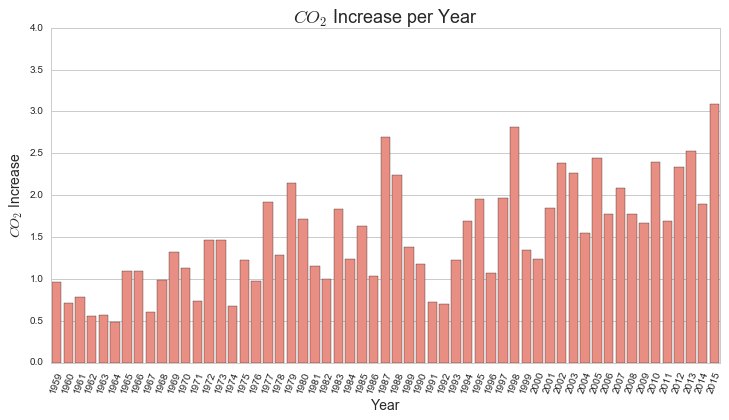

In [5]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=70)
sns.barplot(x='year', y='ppm_per_year', data=data, color='salmon')
plt.ylim((0,4))
plt.ylabel('$CO_2$ Increase', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('$CO_2$ Increase per Year', fontsize=18)
plt.show()

In [6]:
year = np.arange(1959,2016)

In [7]:
with pm.Model() as model:
    
    # prior for distribution of switchpoint year
    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1980)
#     switchpoint = 1980
    
    # prior for pre- and post-switch intercept
    a_0 = pm.Normal('a_0', 0, 1)
    a_1 = pm.Normal('a_1', 0, 1)    
    
    # prior for pre- and post-switch slope
    b_0 = pm.Normal('b_0', 0, 0.1)
    b_1 = pm.Normal('b_1', 0, 0.1)
    
    # priors for sigma
#     s = pm.Uniform('s', 0.0, 0.1)
#     s_0 = pm.HalfCauchy('s_0', 1, testval=0.5)
#     s_1 = pm.HalfCauchy('s_1', 1, testval=0.5)
    
    # Assign slopes to appropriate pre- and post-switchpoint locations
    intercept = pm.switch(switchpoint >= year, a_0, a_1)
    slope = pm.switch(switchpoint >= year, b_0, b_1)
#     sigma = pm.switch(switchpoint >= year, s_0, s_1)
    
    # Data likelihood
#     y_est = a_0 + b_0 * data['year']
    y_est = intercept + slope * data['year']    
    co2_rate = pm.Normal('co2_rate', mu=y_est , sd=0.01, observed=data['ppm_per_year'])

In [8]:
n = 10000
burn = n/2
stride = 5

with model:
    start = pm.find_MAP(fmin=fmin_powell)
#     start['switchpoint'] = start['switchpoint'].astype(np.int64)
    trace = pm.sample(10000, step=pm.Metropolis(), start=start)
    start = trace[-1]
#     step1 = pm.NUTS([a_0, a_1, b_0, b_1], scaling=start)
    step1 = pm.NUTS(scaling=start)
    step2 = pm.Metropolis([switchpoint])
    trace = pm.sample(n, step=[step1, step2], start=start)

 [-----------------100%-----------------] 10000 of 10000 complete in 1036.3 sec

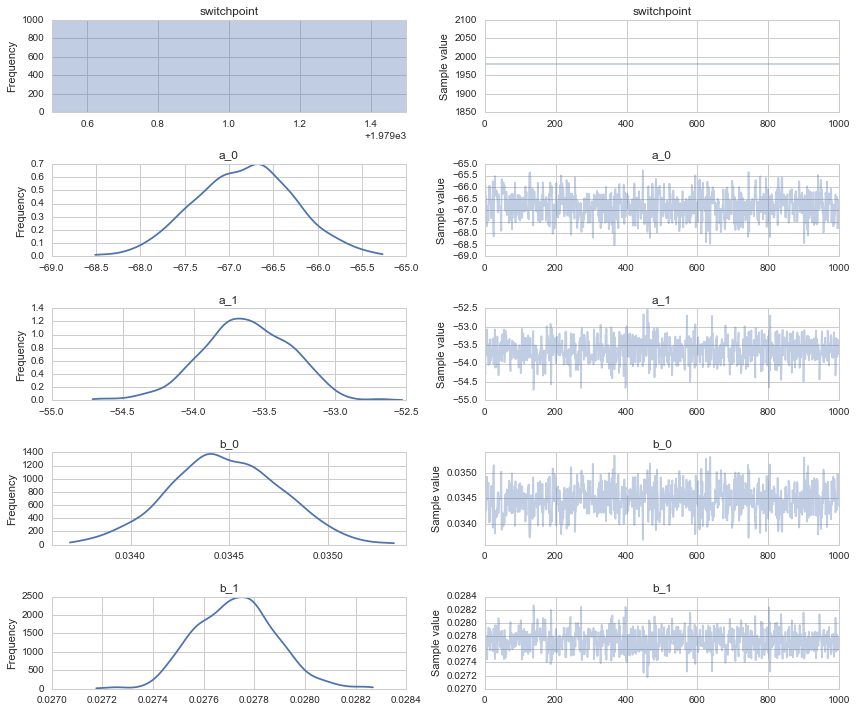

In [9]:
# Only use last half of trace, and every 10th point
pm.traceplot(trace[burn::stride])
# pm.traceplot(trace[-n/2::10], vars=['switchpoint', 'b_0', 'b_1'])
plt.show()

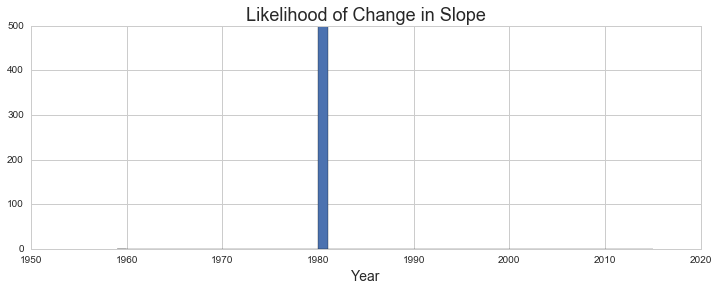

In [10]:
plt.figure(figsize=(12,4))
plt.hist(trace[-n/2::10]['switchpoint'], bins=np.arange(1959, 2016))
plt.title('Likelihood of Change in Slope', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.show()

TypeError: object of type 'FreeRV' has no len()

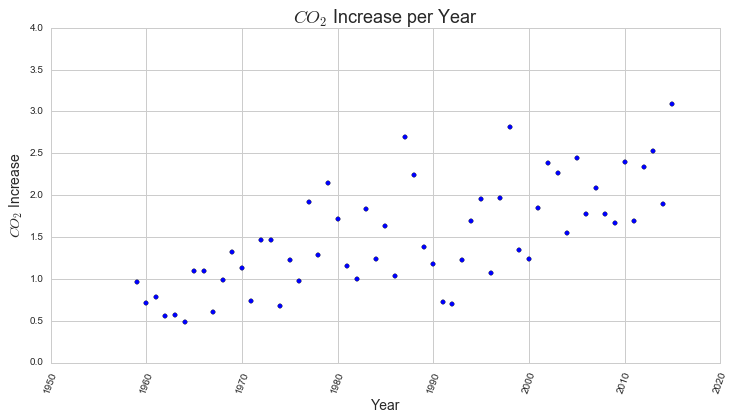

In [11]:
plt.figure(figsize=(12,6))

plt.xticks(rotation=70)
plt.scatter(data['year'], data['ppm_per_year'])
plt.ylim((0,4))
plt.ylabel('$CO_2$ Increase', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('$CO_2$ Increase per Year', fontsize=18)

x = np.arange(1959, switchpoint)
y = np.median(trace[-n/2::10]['a_0']) + np.median(trace[-n/2::10]['b_0']) * x
plt.plot(x, y)

x = np.arange(switchpoint, 2020)
y = np.median(trace[-n/2::5]['a_1']) + np.median(trace[-n/2::5]['b_1']) * x
plt.plot(x, y)

plt.show()

In [ ]:
print(np.median(trace[-n/2::5]['switchpoint']))
print(np.median(trace[-n/2::5]['b_0']))
print(np.median(trace[-n/2::5]['b_1']))

array([1980])

In [35]:
import theano; theano.__version__

'0.8.0rc1.dev-c6979aeeb39178bf8913dd4c642f60914836be29'

In [ ]:
pm.__version__